In [100]:
import scapy.all as sc
import numpy as np
import pandas as pd
from scipy.stats import entropy

SNIFF_TIMEOUT = 1200
BROADCAST = "BROADCAST"
UNICAST = "UNICAST"
PCAP_FILE = "labos-facu-tarde-(30mins).pcap"
ARP_OP_WHO_HAS = 1
ARP_OP_IS_AT = 2

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def agrupar_valores(fuente):
    infoSimb = informacion_simbolos(fuente)
    return set(infoSimb.get_values())

def graficar_histograma(titulo, etiquetaY, etiquetasBarras, tamanosBarras):
    #configuracion de colores
    colorBarras = '#3D7DAA' #34627C'
    colorBordeBarras = '#1E4150'#'#3C7DAA'
    colorFondo = '#E6E6E6'    
    colorFuente = '#222020'

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    #configuracion de la grilla y el fondo
    ax.grid(zorder=0)
    ax.grid(True)
    plt.grid(b=True, which='both', color='w',linestyle='-', linewidth=1)
    ax.set_axis_bgcolor(colorFondo) 
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['right'].set_color('w')

    #tamanosBarras = agrupar_valores(tamanosBarras)

    ind = np.arange(len(tamanosBarras)) # las posiciones x de las barras tamanosBarras.size
    anchoBarra = 0.35                         # ancho de las barras

    rects1 = ax.bar(ind, tamanosBarras, anchoBarra, color=colorBarras, edgecolor=colorBordeBarras, zorder=3)

    # ejes y etiquetas
    ax.set_xlim(-anchoBarra,len(ind)+anchoBarra)
    ax.set_ylim(0, max(tamanosBarras)+1)
    #ax.set_xlim(0, 100)

    ax.set_ylabel(etiquetaY)
    ax.set_title(titulo)
    xTickMarks = etiquetasBarras
    
    ax.set_xticks(ind+anchoBarra)
    xtickNames = ax.set_xticklabels(xTickMarks)
    plt.setp(xtickNames, rotation=0, fontsize=10, weight='bold', color=colorFuente)
    
    
    return ax.get_figure()

def graficar_comparacion_simbolos_fuente(titulo, etiquetaY, etiquetasBarras, entropia, tamanosBarras):    
    fig = graficar_histograma(titulo, etiquetaY, etiquetasBarras, tamanosBarras)

    colorEntropia = '#BF111D'    
    plt.axhline(entropia, color='r', linestyle='-', linewidth=2, zorder=4)

    red_patch = mpatches.Patch(color=colorEntropia, label='Entropia')
    plt.legend(handles=[red_patch])
    fig.savefig("gr.png", figsize=(1200,1200),  dpi=200)
    plt.show()

def graficar_comparacion_simbolos_entropia(fuente):   
    titulo = "Comparacion entre la informacion de los simbolos y la entropia de la fuente"
    etiquetaY ="Informacion"
    etiquetasBarras = ["UNICAST", "BROADCAST"]    
    graficar_comparacion_simbolos_fuente(titulo, etiquetaY, etiquetasBarras, entropia_fuente(fuente), informacion_simbolos(fuente))

def graficar_comparacion_simbolos_entropia_agrupados(fuente):   
    titulo = "Comparacion entre la informacion de los simbolos y la entropia de la fuente"
    etiquetaY ="Informacion"
    etiquetasBarras = []    
    
    tamanosBarrasAgrupados = set(informacion_simbolos(fuente).values)
    graficar_comparacion_simbolos_fuente(titulo, etiquetaY, etiquetasBarras, entropia_fuente(fuente), tamanosBarrasAgrupados)


In [140]:
packages = sc.sniff(offline=PCAP_FILE, lfilter=lambda x: x.haslayer(sc.ARP))
arp_packages = map(lambda p: p["ARP"], packages)
who_has_packages = filter(lambda p : p.op == ARP_OP_WHO_HAS,arp_packages)
is_at_packages = filter(lambda p : p.op == ARP_OP_IS_AT, arp_packages)

Entropia de la fuente = 4.7858033393


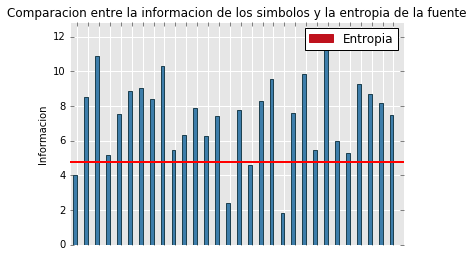

In [142]:
fuente_s2 = pd.Series([p.pdst for p in who_has_packages])
contadores = fuente_s2.value_counts()
#convierto contadores a un array y luego este a un conjunto
#valores_diferentes = set(contadores.values)
#print "valores diferentes:", len(valores_diferentes)

print "Entropia de la fuente =", entropia_fuente(fuente_s2)

graficar_comparacion_simbolos_entropia_agrupados(fuente_s2)

Entropia fuente S = 0.190928228172
BROADCAST    3709
UNICAST       112
dtype: int64
BROADCAST    0.04292
UNICAST      5.09238
dtype: float64


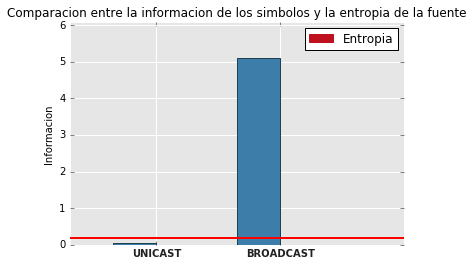

In [143]:
def simbolo_s(package):
    if p.dst == 'ff:ff:ff:ff:ff:ff':
        return BROADCAST
    else:
        return UNICAST

def entropia_fuente(fuente):
    counts = fuente.value_counts()
    return entropy(base=2,pk=counts.as_matrix())

def informacion_simbolos(fuente):
    counts = fuente.value_counts() # ocurrencias de cada ip
    total = counts.sum()
    probs = counts / float(total)
    return pd.Series(- np.log2(probs), index=counts.index)

fuente = pd.Series([simbolo_s(p) for p in packages])
contadores = fuente.value_counts()
print "Entropia fuente S =", entropia_fuente(fuente)
print contadores
print informacion_simbolos(fuente)

graficar_comparacion_simbolos_entropia(fuente)

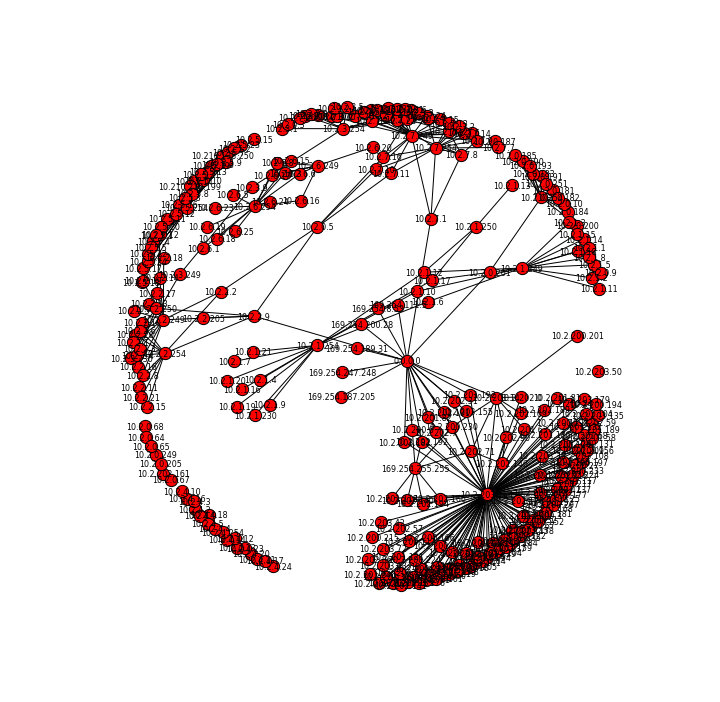

Cantidad de Nodos:  303
Cantidad de Enlaces:  380


In [146]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab

# en cantidadMinimaInteracciones pasamos la cantidad minima 
# de interacciones que tiene que tener el nodo para ser graficado
def crear_grafo_cmin(paquetes, cMinIntNodo):
    grafo = nx.Graph()
    
    fuente = pd.Series([p.pdst for p in who_has_packages])
    contadores = fuente.value_counts()
    etiquetas={}

    for paquete in paquetes:
        agregar_paquete(grafo, paquete, etiquetas, contadores, cMinIntNodo)
    
    plt.figure(figsize=(12,12)) 

    pos=nx.spring_layout(grafo)
    nx.draw_networkx_labels(grafo,pos,etiquetas,node_size=60,font_size=8)
    nx.draw(grafo,pos,node_size=150,font_size=8)
    pylab.show()
    return grafo

def crear_grafo(paquetes):
    return crear_grafo_cmin(paquetes, 0)

def agregar_paquete(grafo, paquete, etiquetas, contadores, cMinIntNodo):
    origen = paquete.psrc
    destino = paquete.pdst
    cantNodos = 0
    
    if (contadores[destino]>=cMinIntNodo):
        if (not grafo.has_node(origen)):
            grafo.add_node(origen)
            etiquetas[origen]=origen
            cantNodos = cantNodos + 1
        if (not grafo.has_node(destino)):
            grafo.add_node(destino)
            etiquetas[destino]=destino
            cantNodos = cantNodos + 1
        grafo.add_edge(origen, destino)
    
    #grafo.remove_node("0.0.0.0")
    
    #nx.draw(grafo, pos, node_color=range(cantNodos), cmap=plt.cm.Blues)
    return grafo

        
A = crear_grafo(who_has_packages)        


print "Cantidad de Nodos: ", A.number_of_nodes()
print "Cantidad de Enlaces: ", A.number_of_edges()

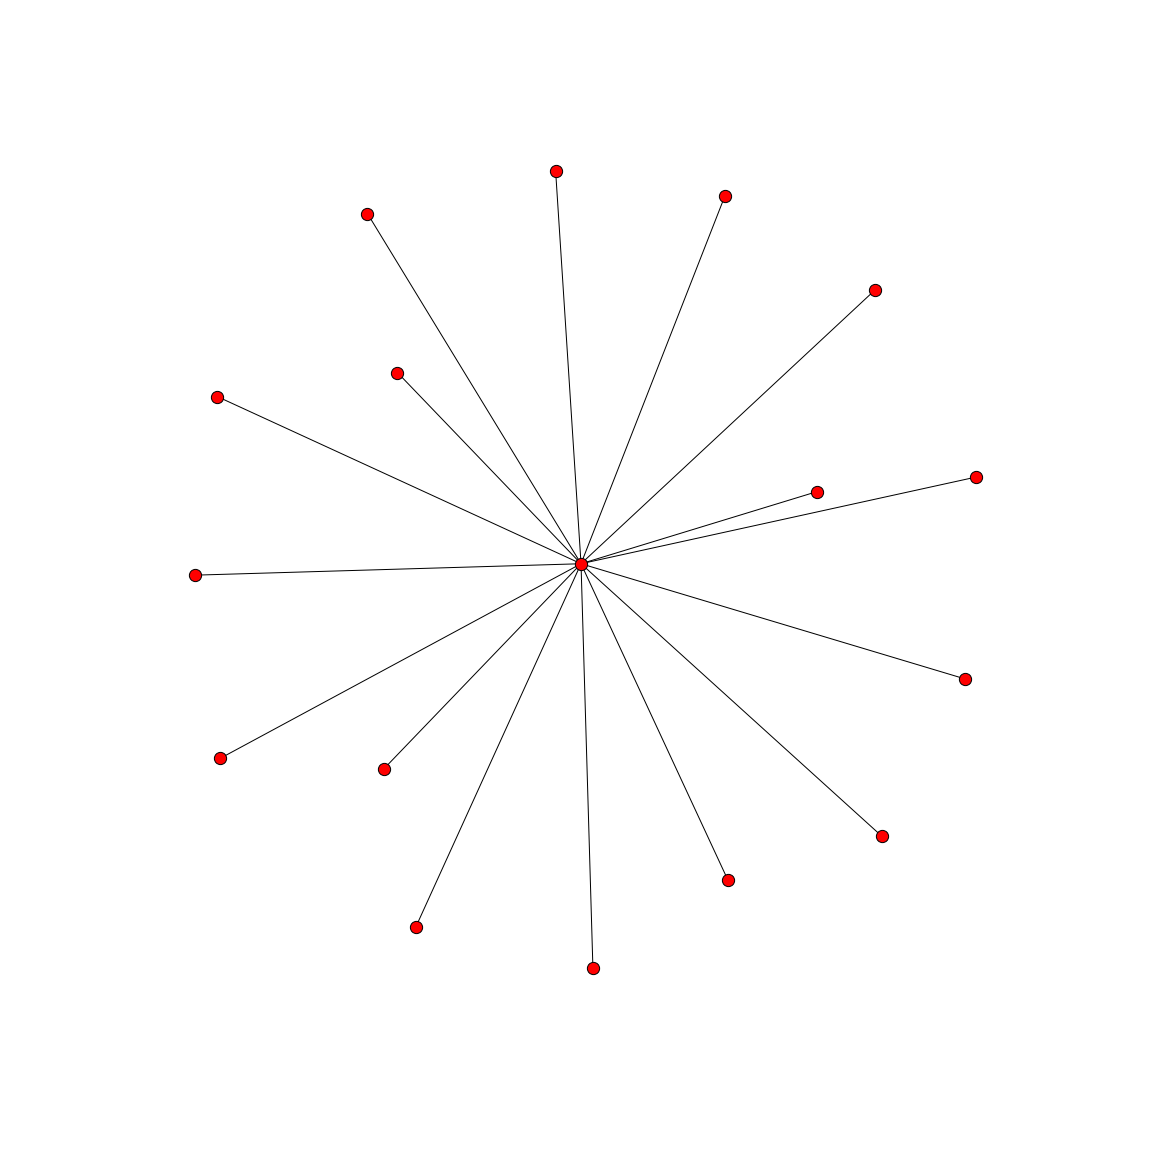

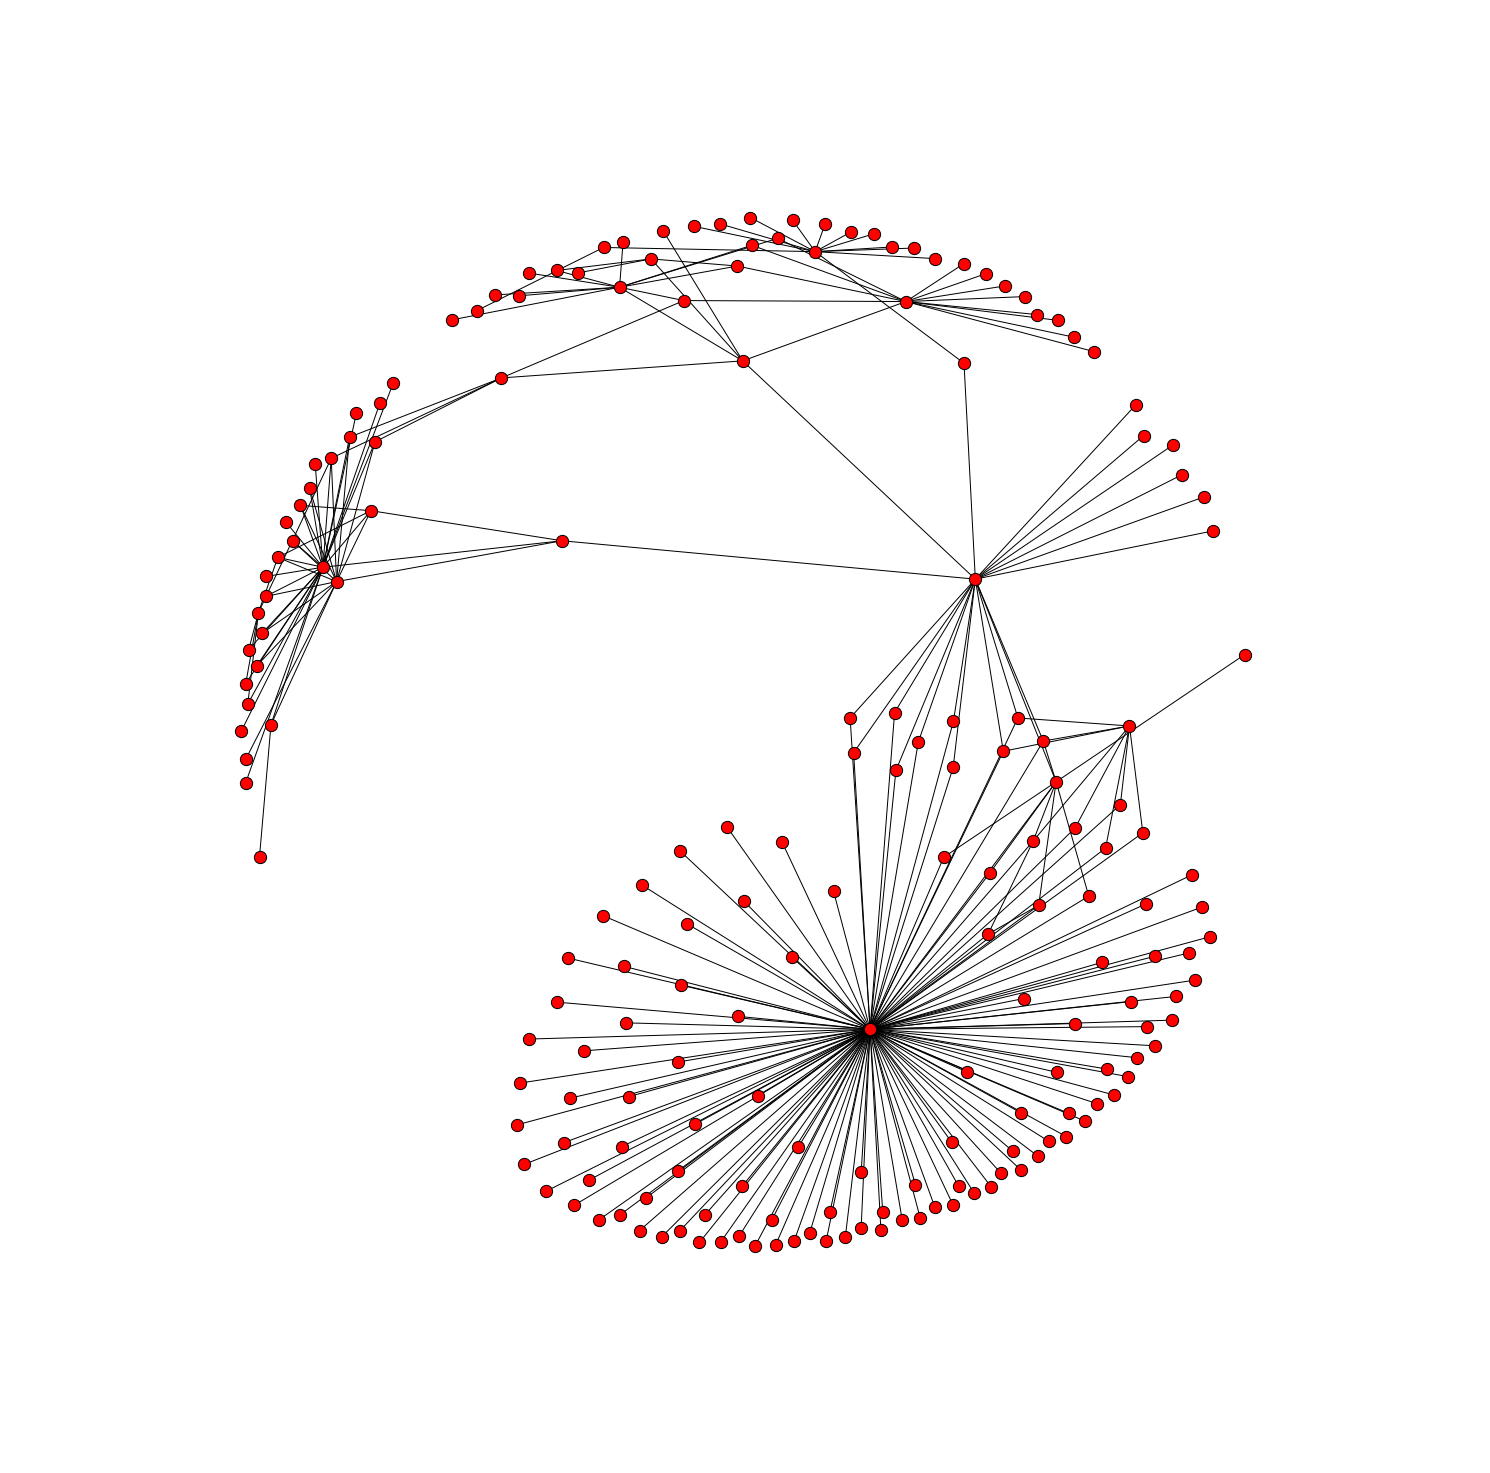

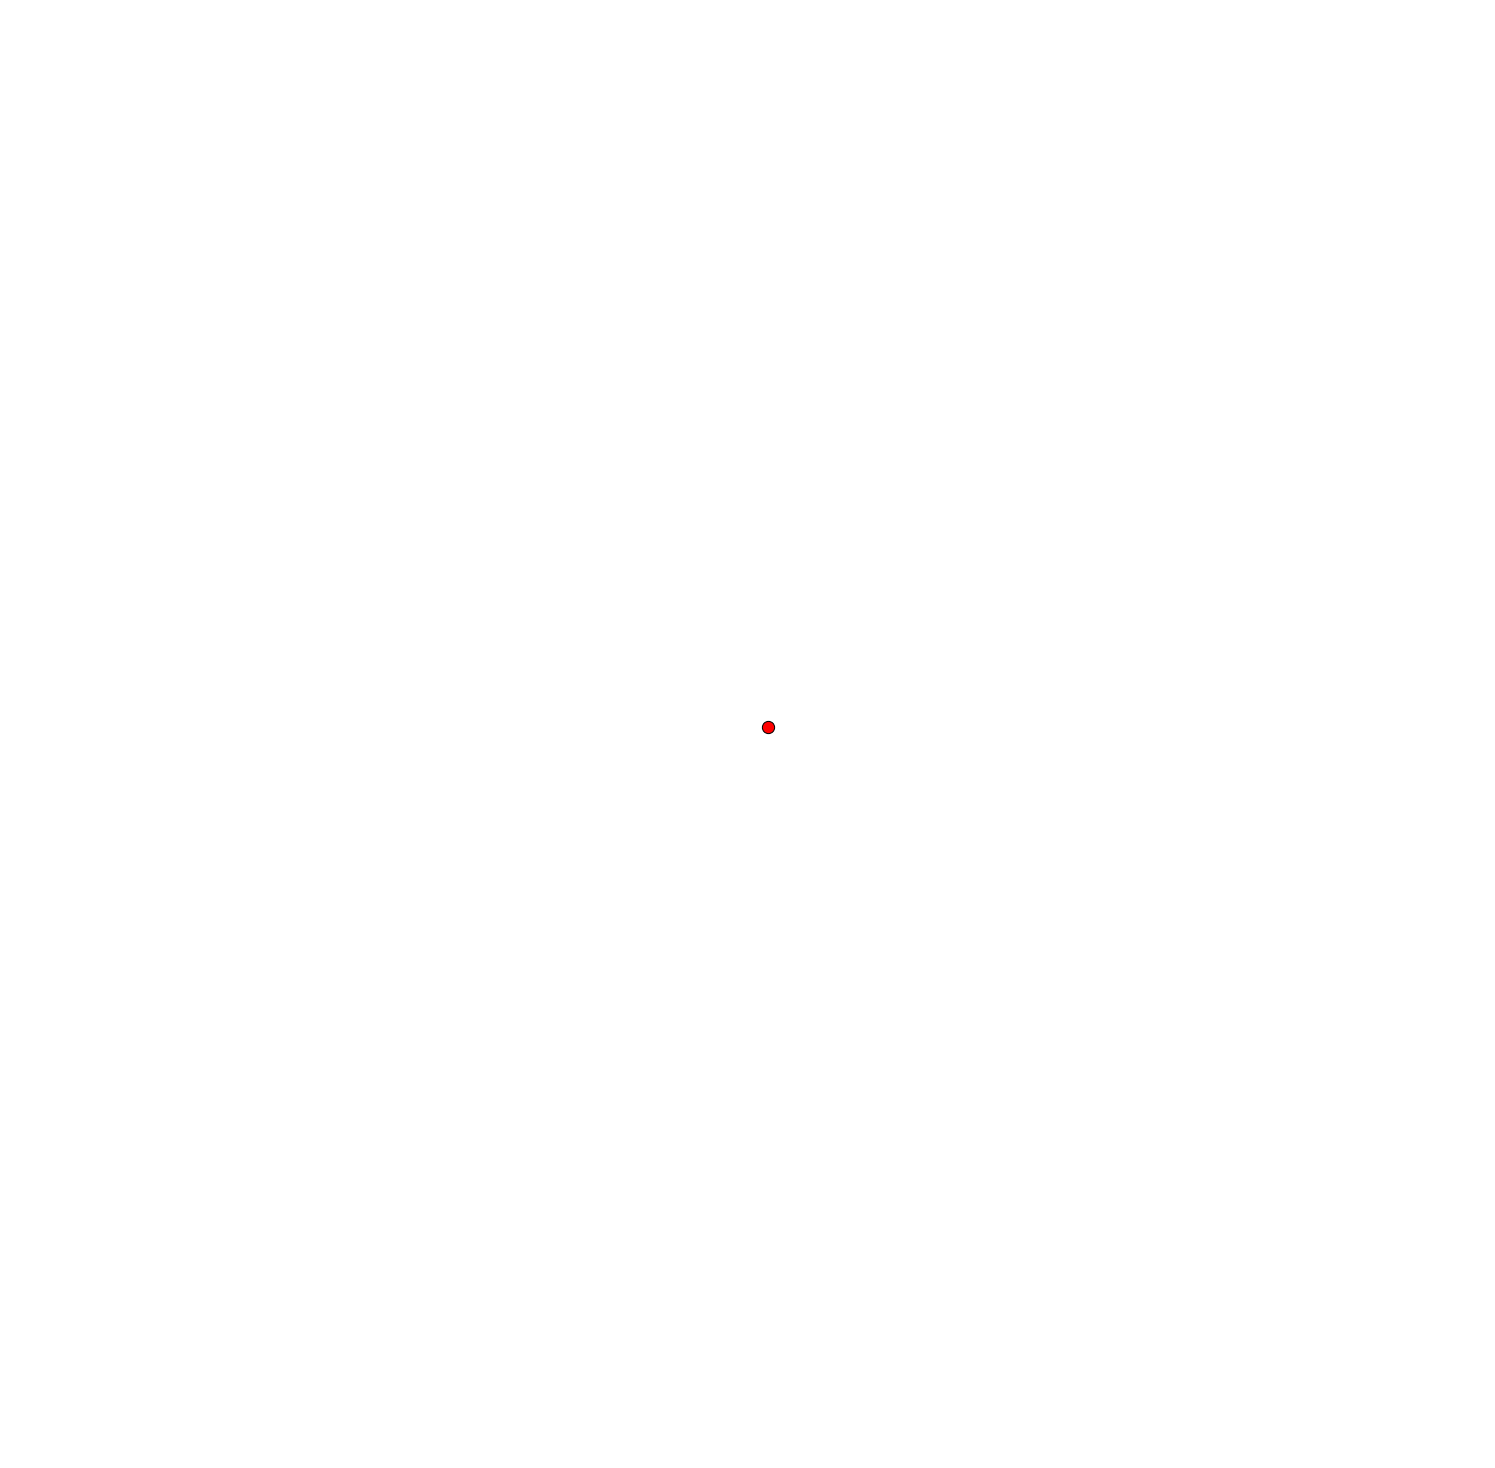

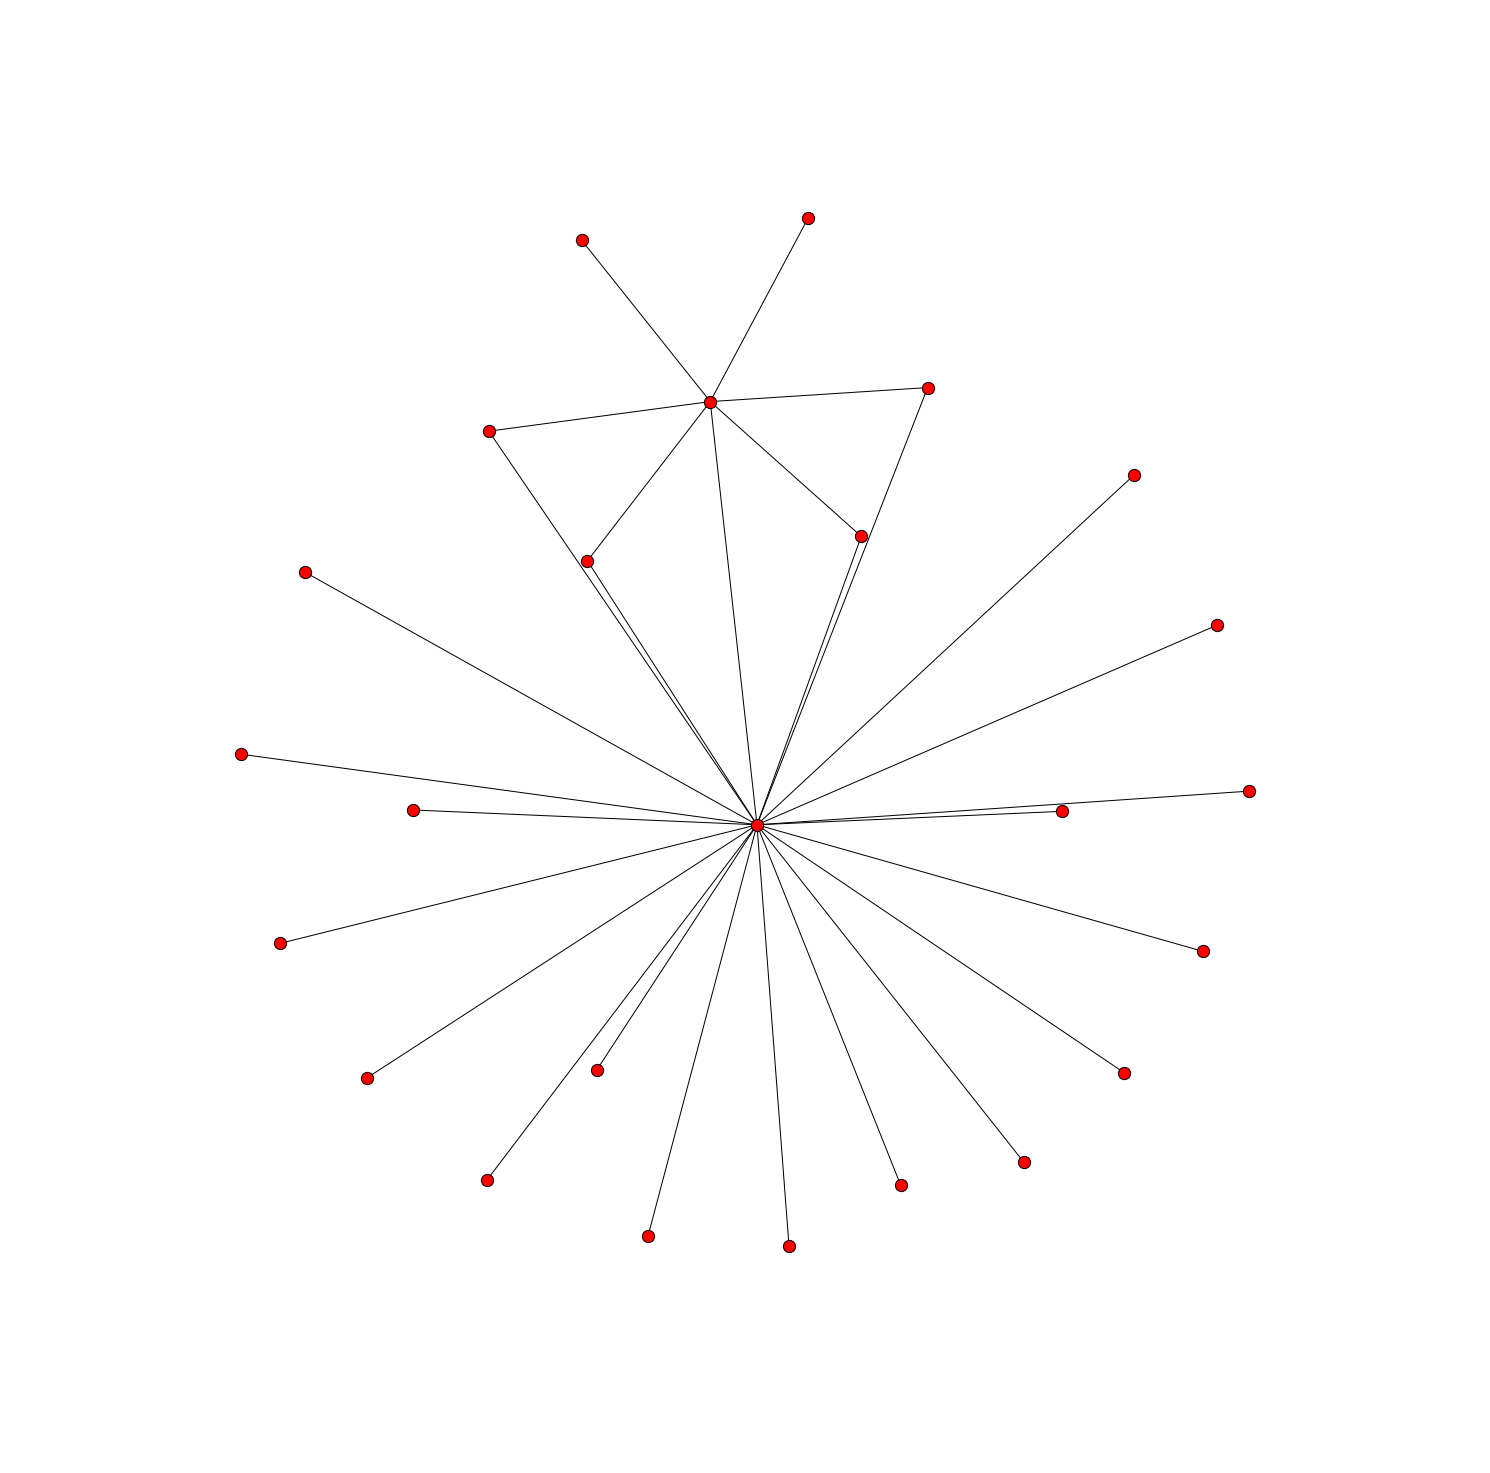

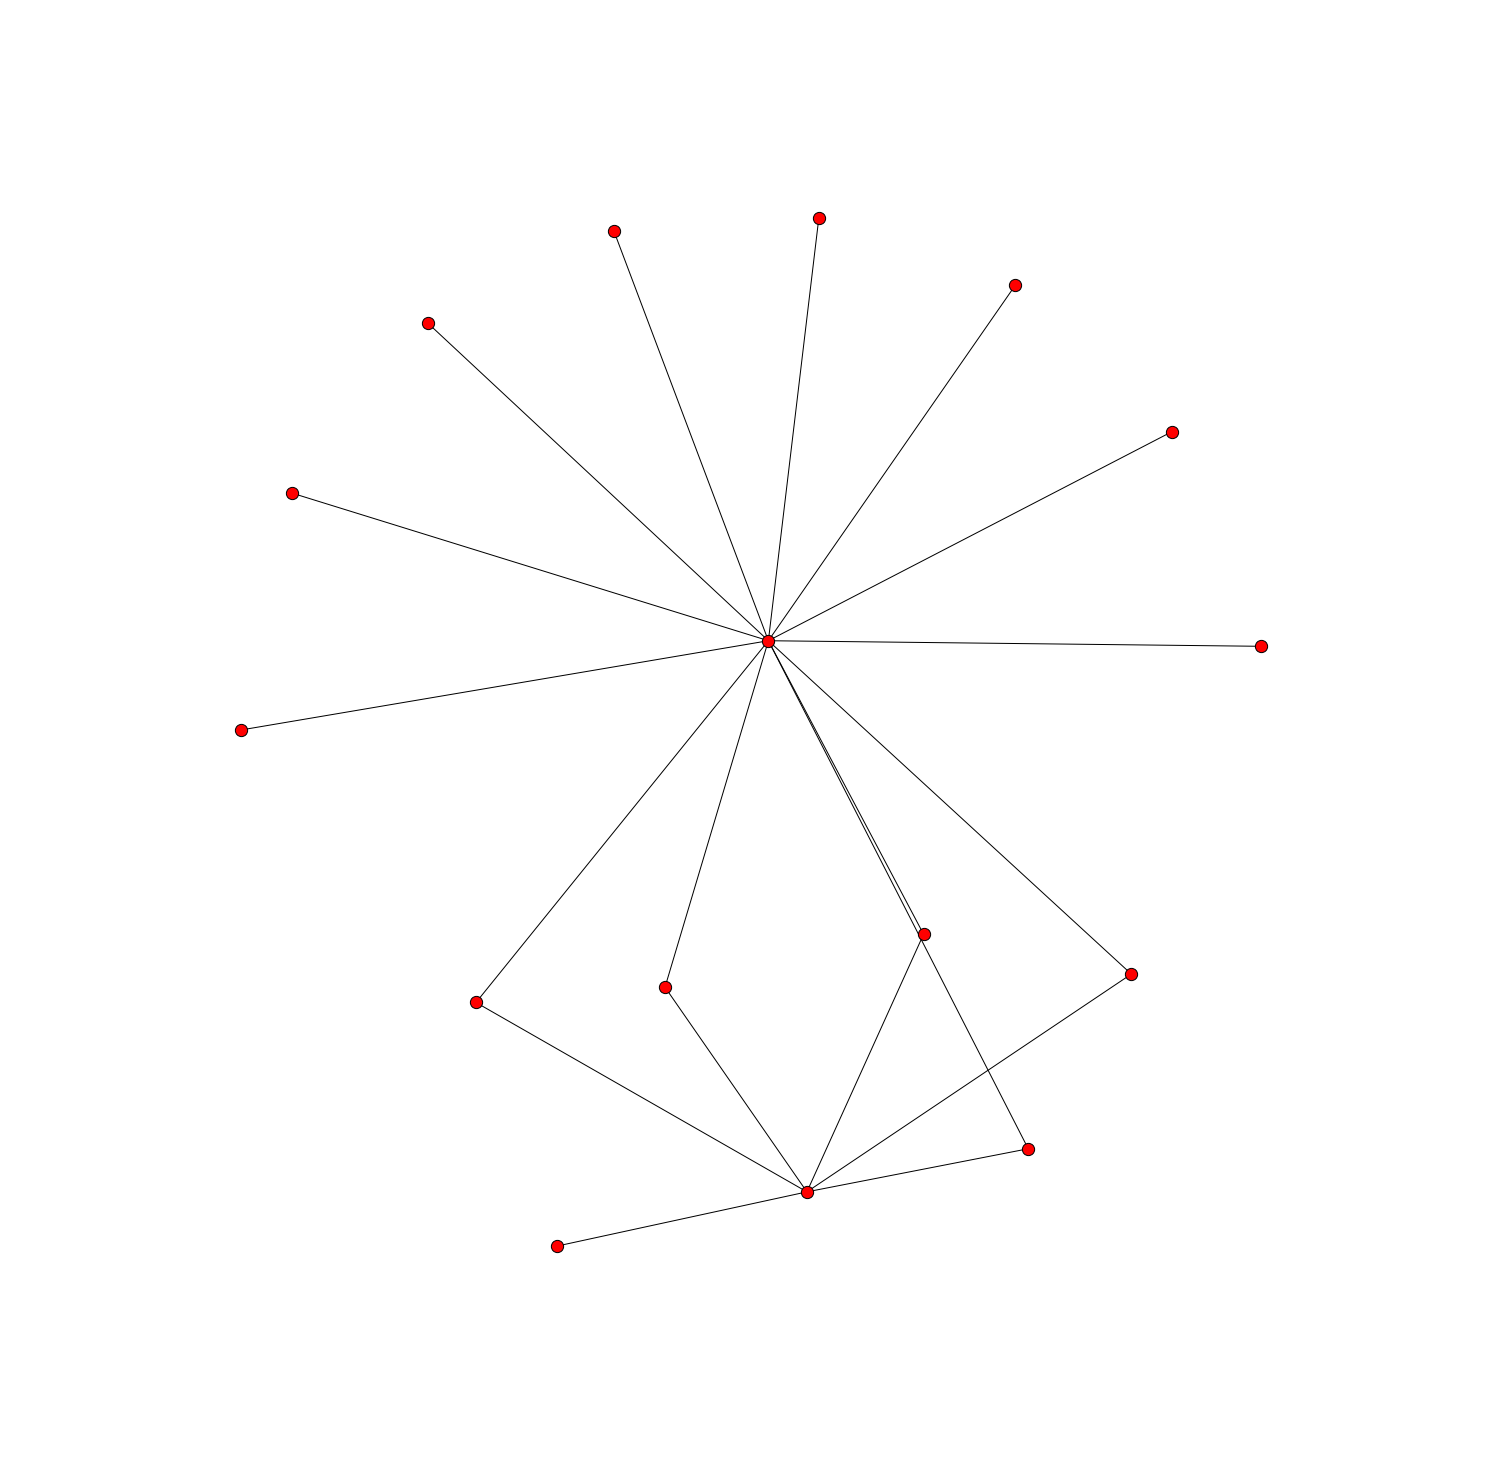

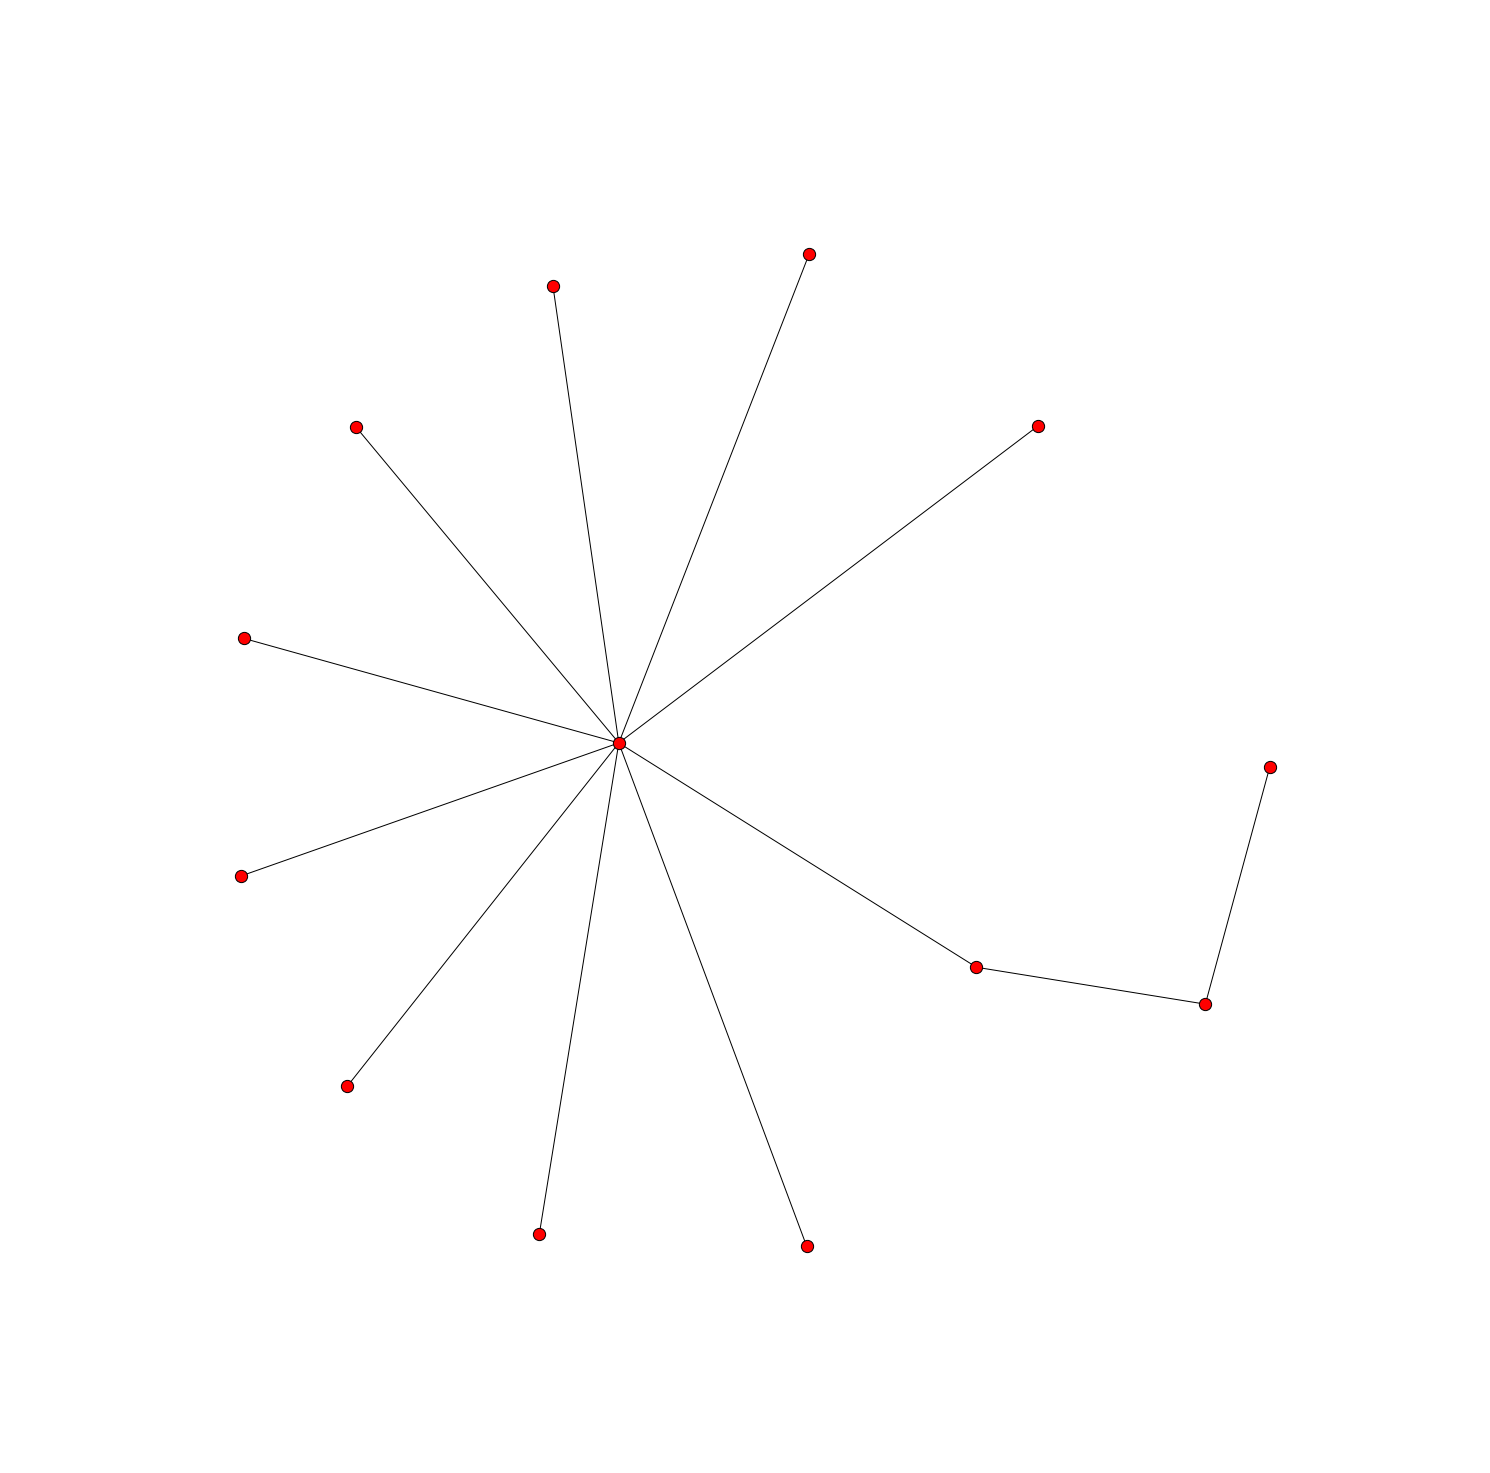

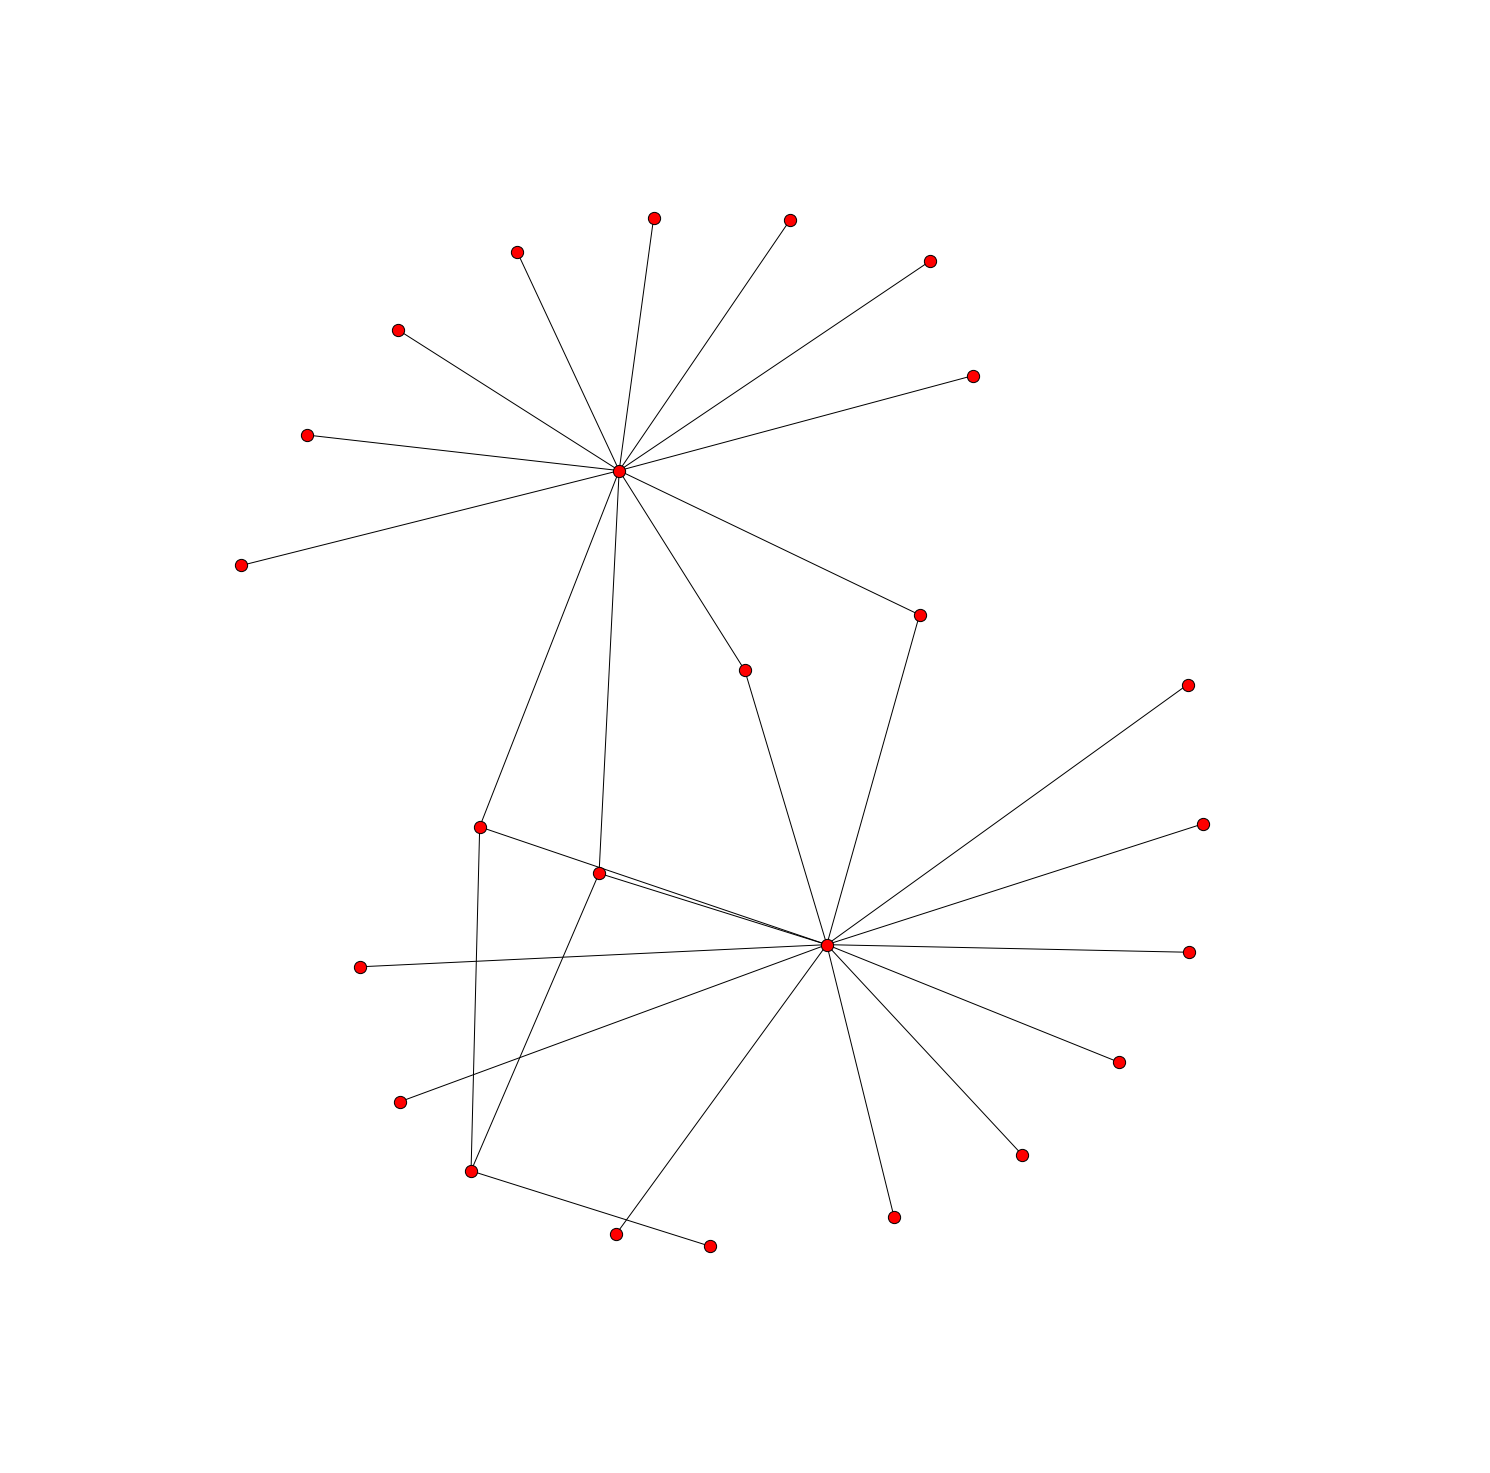

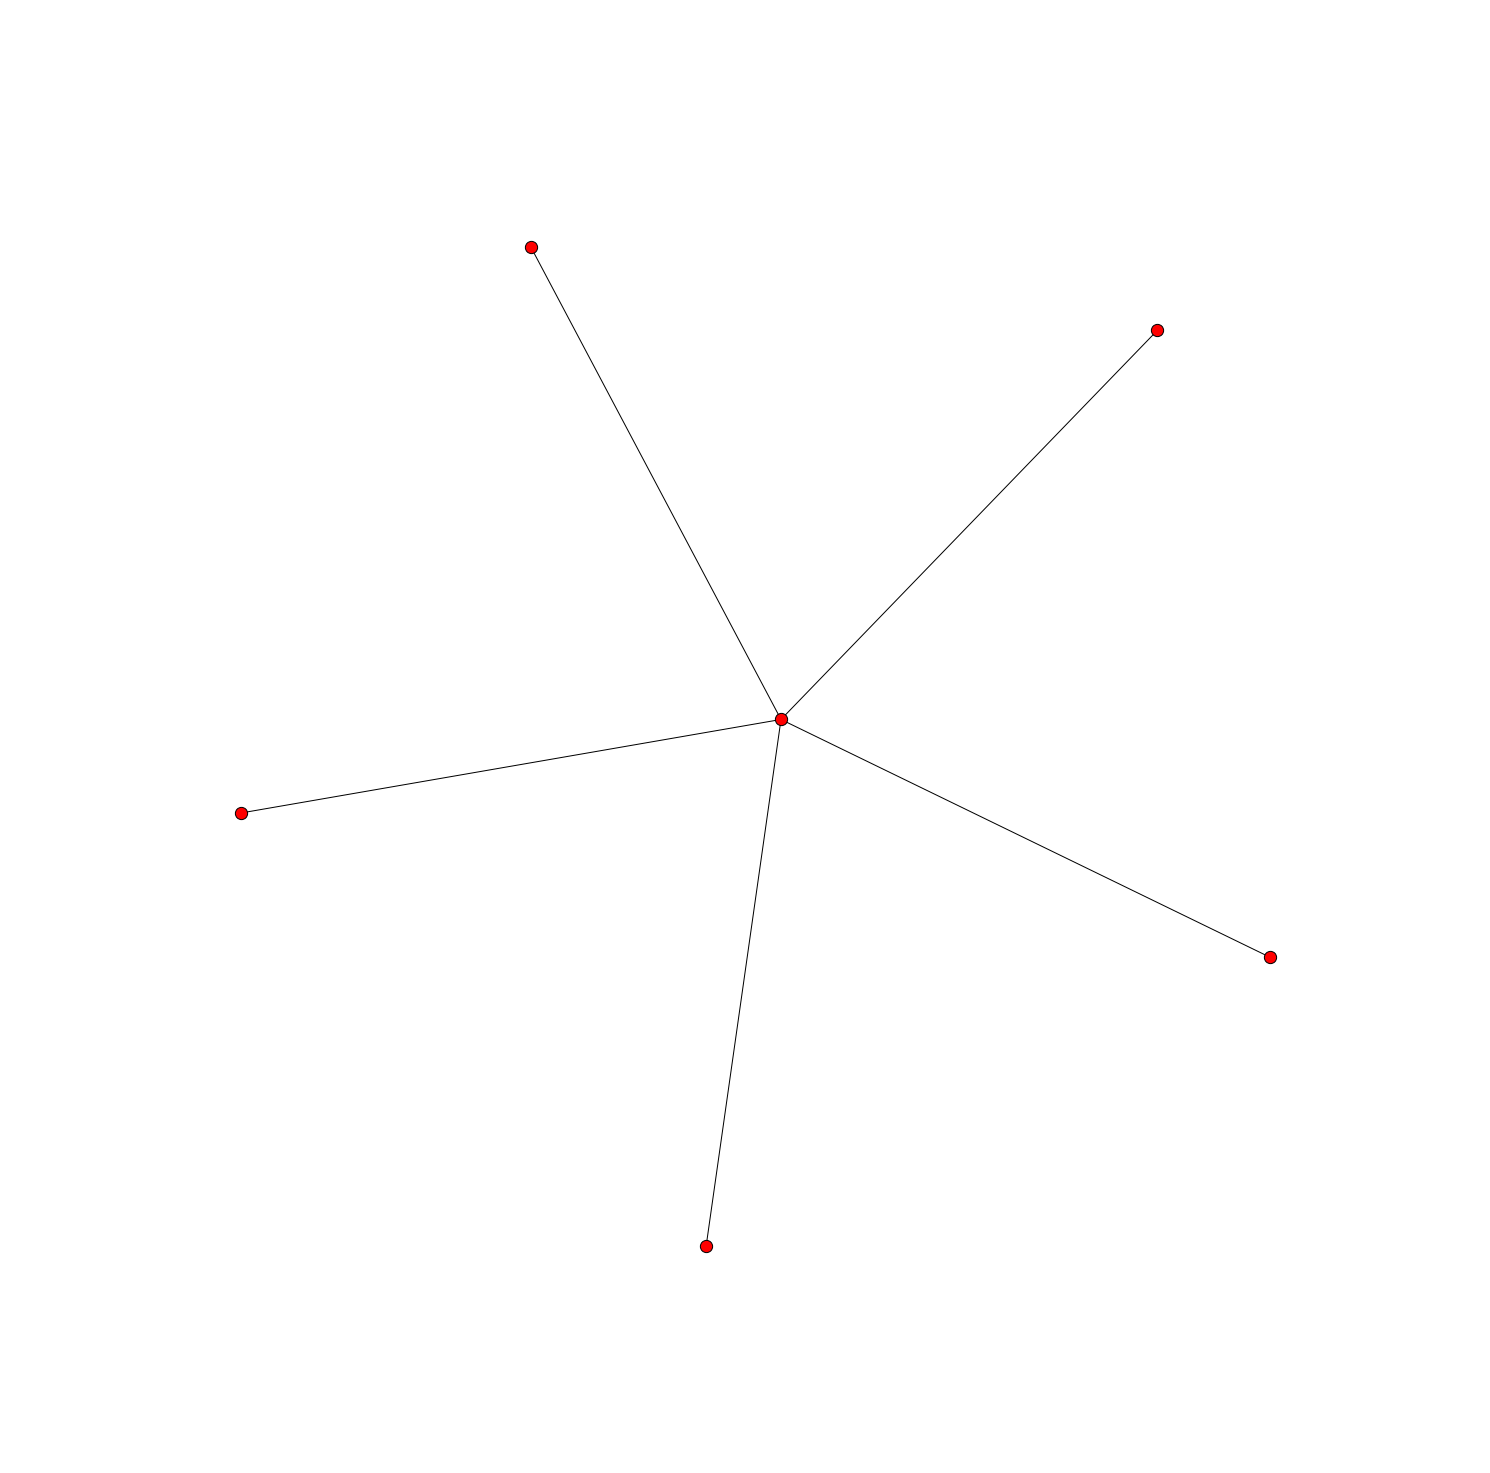

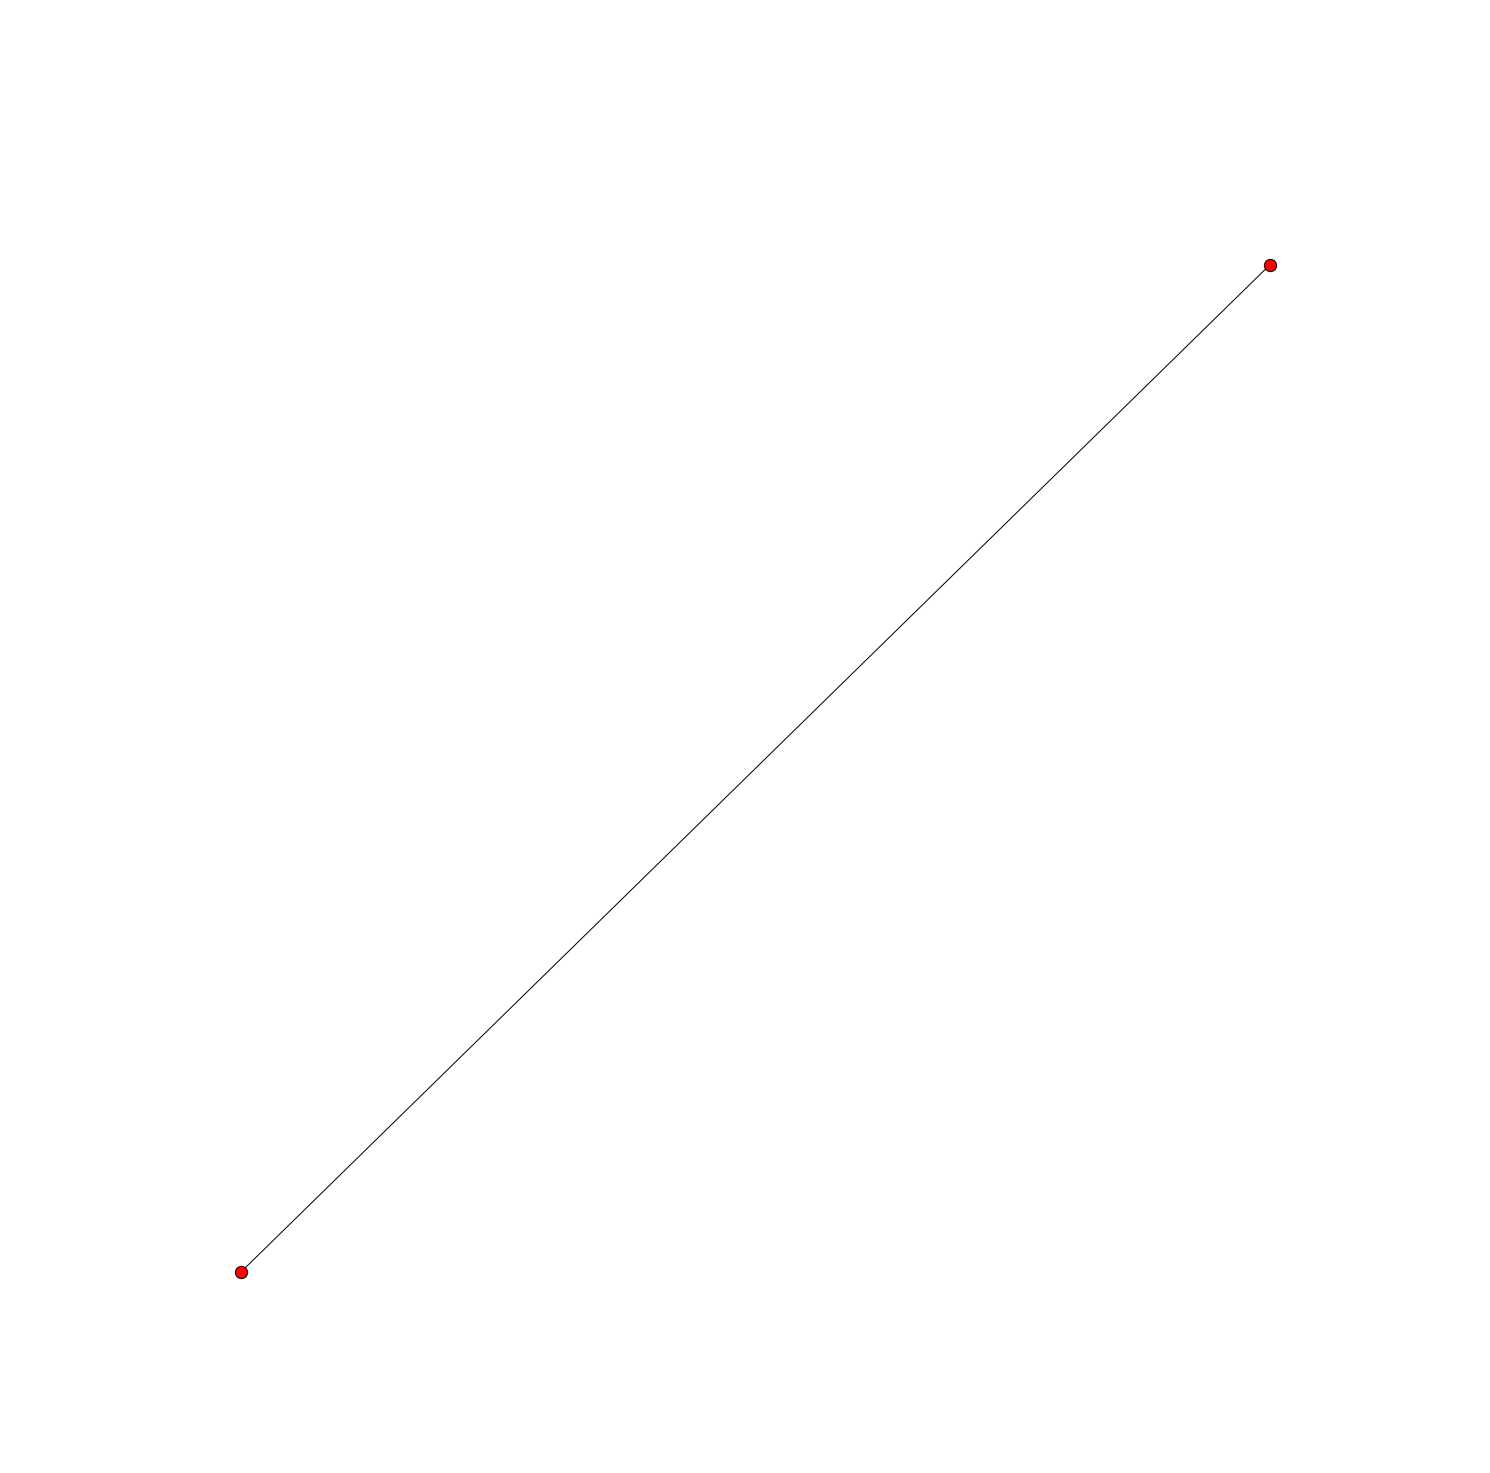

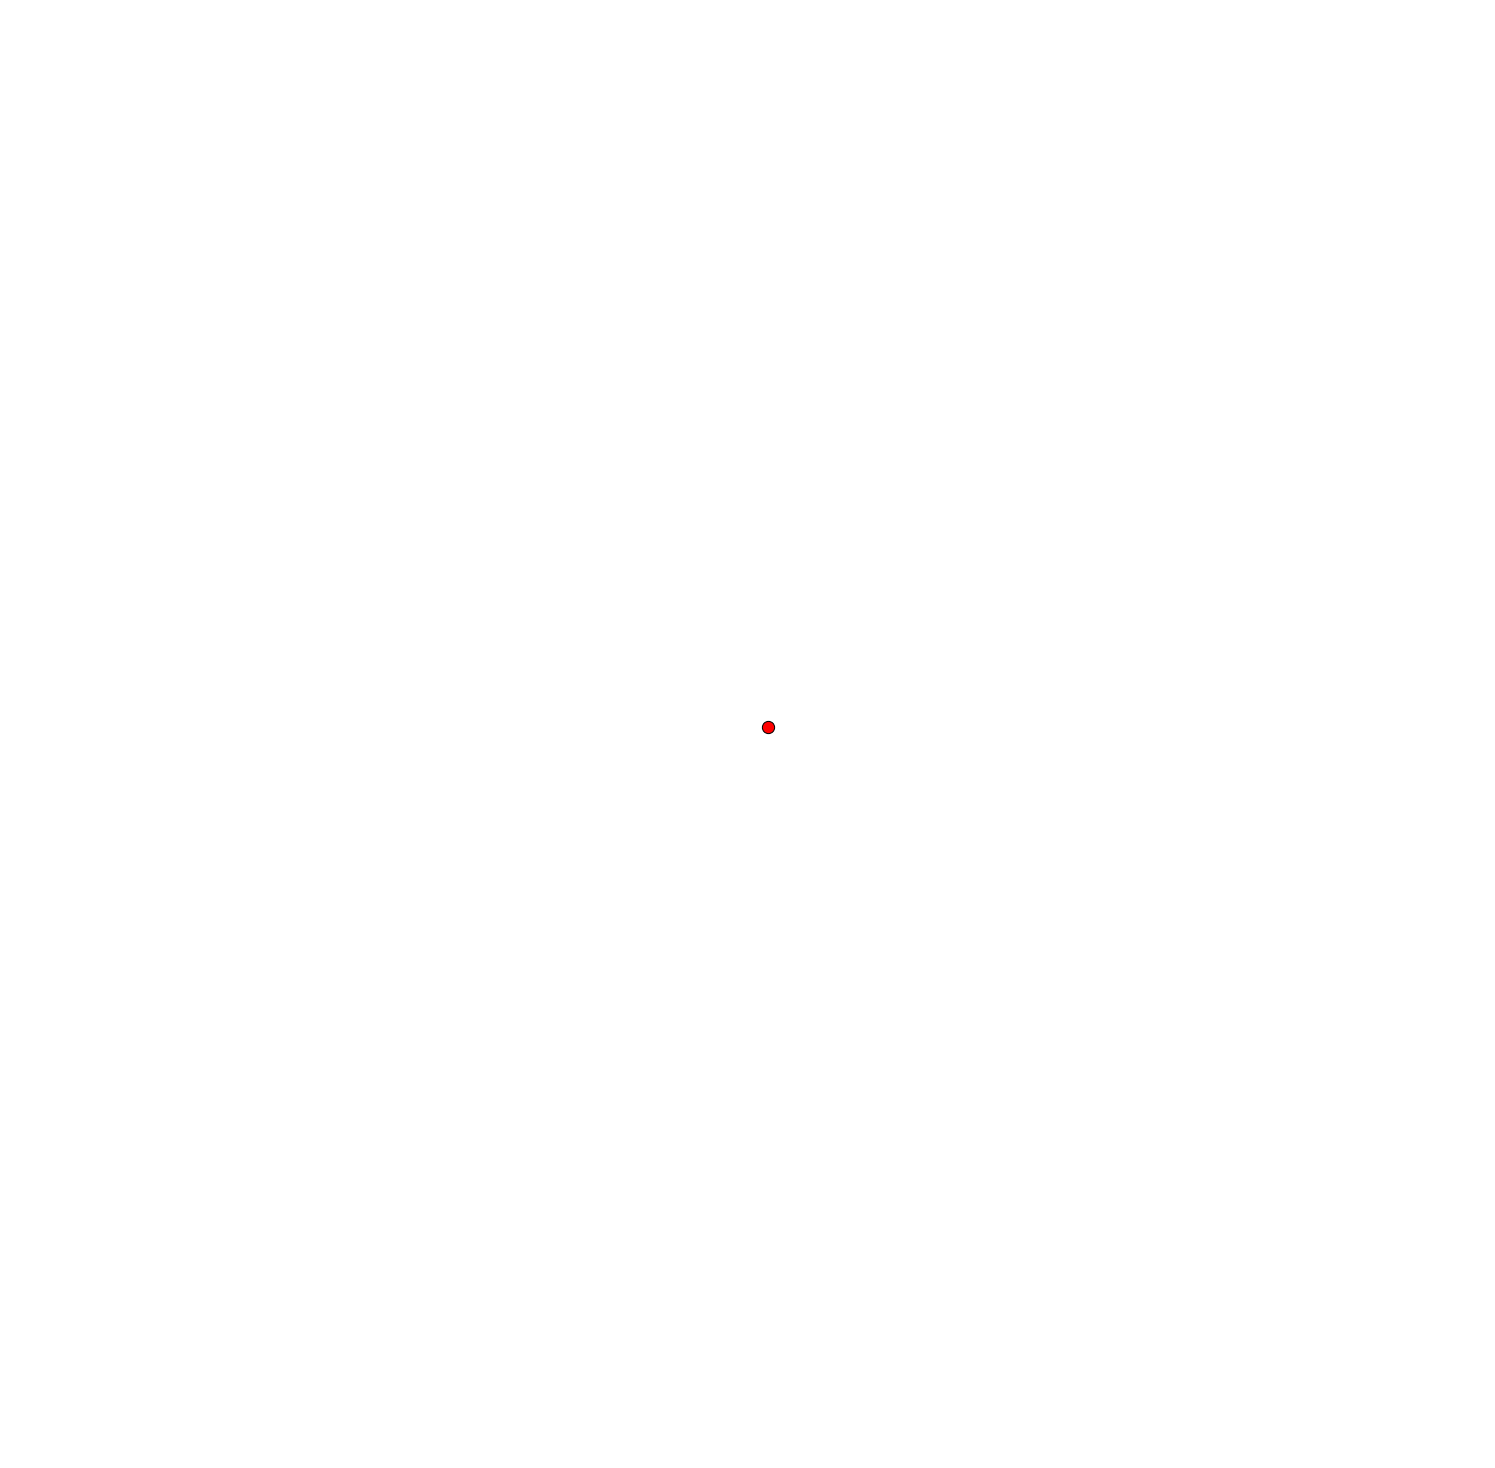

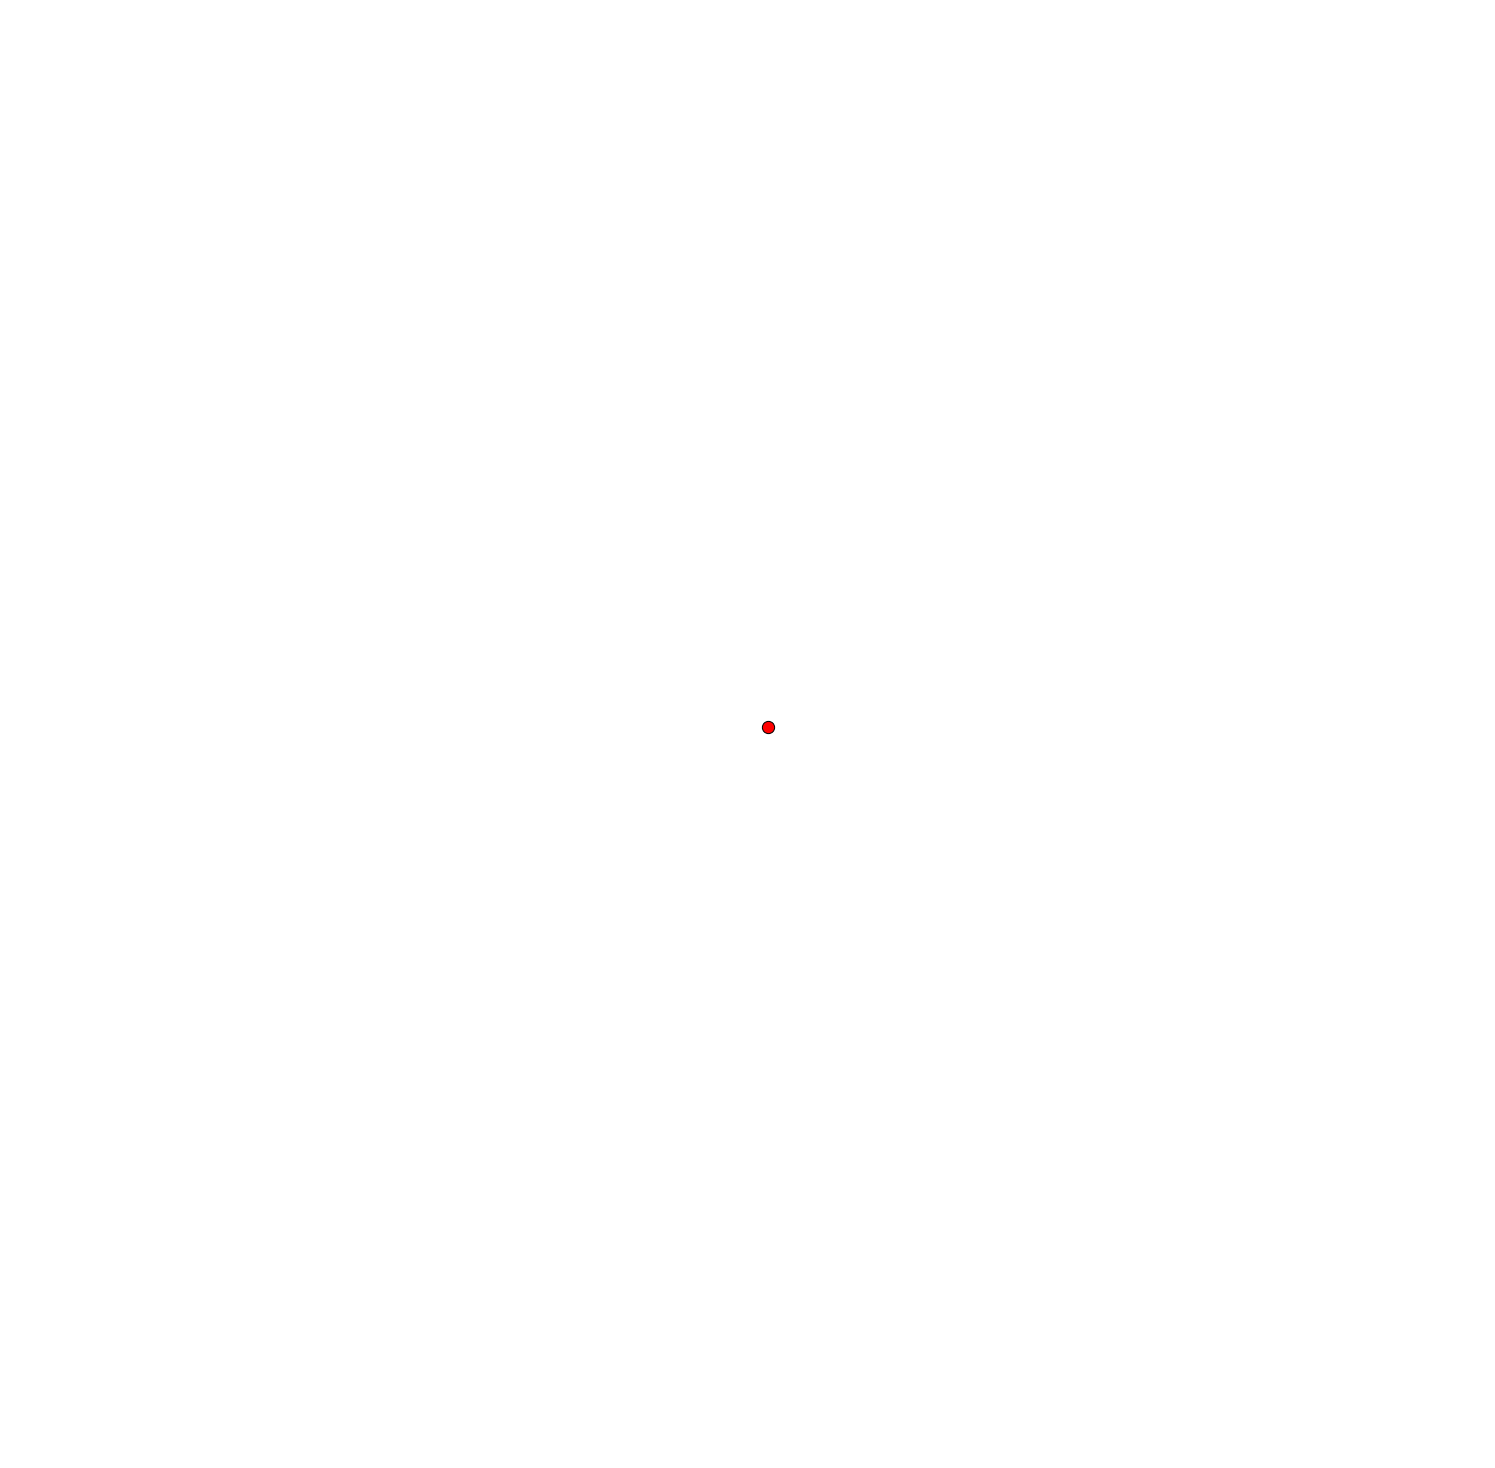

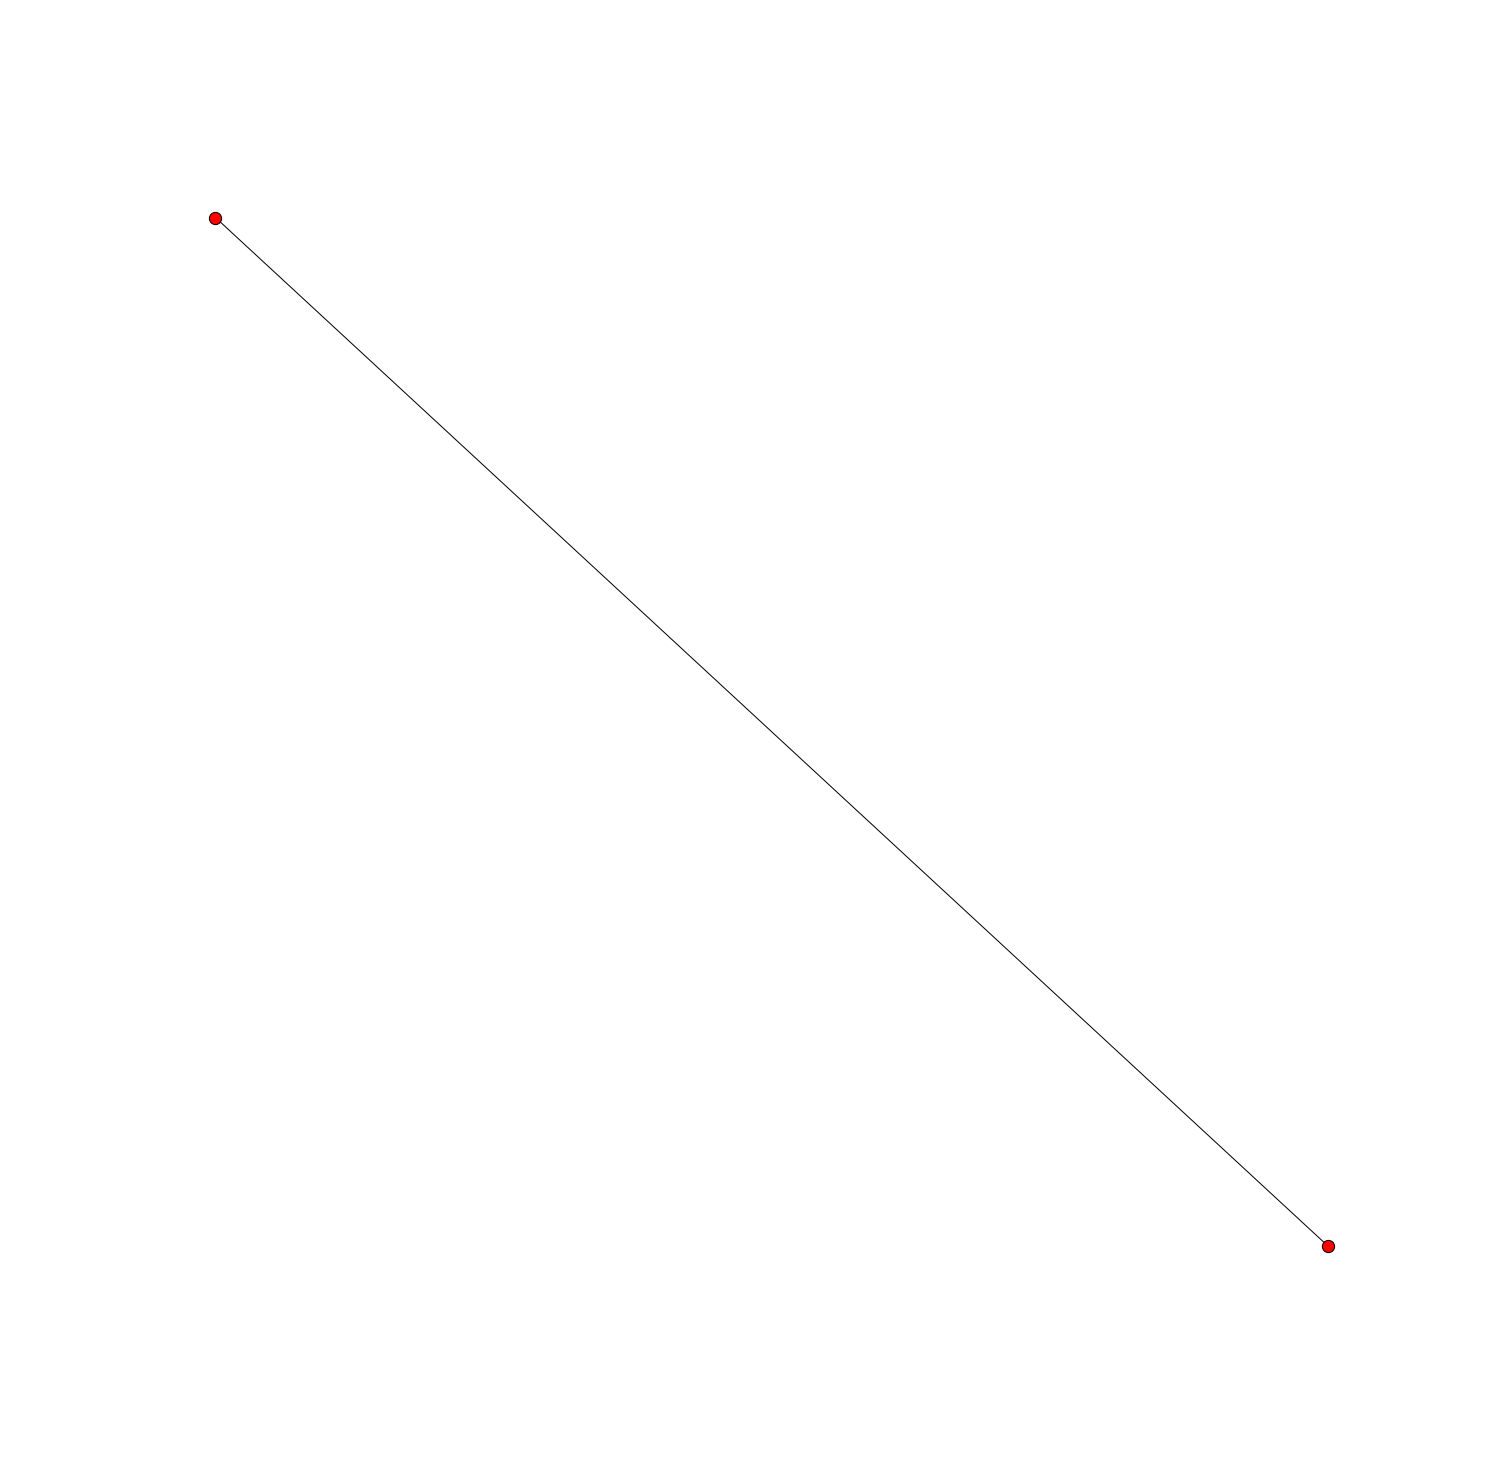

In [149]:
def setear_esquema_sin_etiquetas(grafo, ancho, alto, tamano_nodo, tamano_fuente):
    plt.figure(3, figsize=(ancho, alto)) 
    pos=nx.spring_layout(grafo)
    nx.draw(grafo, pos, node_size=tamano_nodo, font_size=tamano_fuente)

def setear_esquema(grafo, ancho, alto, tamano_nodo, tamano_fuente):
    plt.figure(3, figsize=(ancho, alto)) 
    pos=nx.spring_layout(grafo)
    print etiquetas
    nx.draw_networkx_labels(grafo,pos,etiquetas,node_size=60,font_size=8)
    nx.draw(grafo, pos, node_size=tamano_nodo, font_size=tamano_fuente)

#G.remove_edge("0.0.0.0", "10.2.2.9")

graphs = list(nx.connected_component_subgraphs(A))

for graph in graphs:
    setear_esquema_sin_etiquetas(graph, 20, 20, 150, 8)
    pylab.show()